# Simulação de inversores em cascata dado como entrada uma função senoidal de 1.5V de amplitude

O objetivo do código é, a partir dos dados do arquivo *inversor-data.csv* que informa o **Vin** e o **Vout** de um inversor, conseguir simular a execução de dois inversores em cascata, com o objetivo de transformar o sinal variado de entrada em uma saída perto de binária.

Primeiramente, terá a parte de importação de bibliotecas, o tratamento dos dados do arquivo *.csv* e a criação da função senoidal de amplitude 1.5V

Segundo, o código irá consistir de dois modelos de simulação, descritos a seguir.

### Verificação em busca

Dado o valor x de entrada do inversor, é pesquisado no conjunto de dados o index de qual o valor x é mais próximo, e, com esse index, é obtido o valor de saída correspondente.

### Sigmoid Fit

Pelo fato de que a função de um inversor se aparenta com uma sigmoid, é feito um treinamento dos dados para elaborar um modelo de regressão com a função **sigmoid** em base.

## Importação e Tratamento dos dados

In [104]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use(['ggplot'])

In [105]:
# Importando os dados do inversor
df = pd.read_csv("inversor-data.csv", delimiter=";")

df["input"] = df["input"].apply(lambda x: float(x.replace(",", ".")))
df["output"] = df["output"].apply(lambda x: float(x.replace(",", ".")))

df.head()

,input,output
0,0.225617,2.992150
1,0.302294,2.992150
2,0.378738,2.984437
3,0.448413,2.971831
4,0.507035,2.958332


In [106]:
# Criando a função senoidal com amplitude 1.5V de variação 0-3V
x = np.linspace(0, 8*math.pi, 10000)
Vin = 1.5*np.sin(x) + 1.5

Vin.min(), Vin.max()

(1.8509209720463105e-08, 2.9999999814907903)

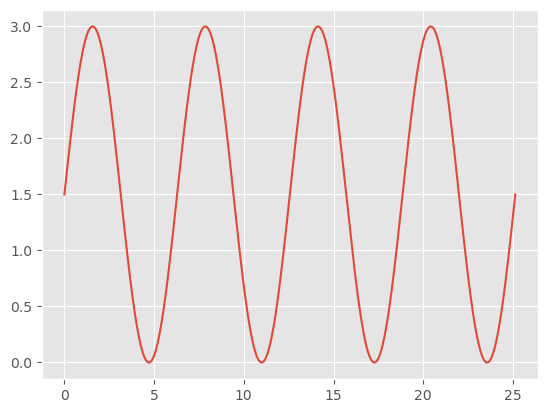

In [107]:
plt.plot(x, Vin)
plt.show()

## Verificação em busca

In [108]:
# Criação da função de inversor baseado em busca

def inversor_search_model(x: float) -> float:
    diff = abs(df["input"] - x)
    index = diff.sort_values().index[0]
    return df.loc[index]["output"]

In [109]:
# Testando o modelo
inversor_search_model(2.0)

0.217629362470276

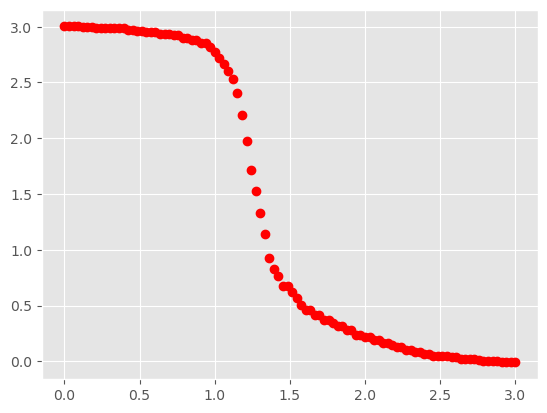

In [110]:
# Verificação com os dados originais

xi = np.linspace(0, 3, 100)
yi = [inversor_search_model(i) for i in xi]

plt.plot(xi, yi, "ro")
plt.show()

### Criando o gŕafico de simulação

In [111]:
# Adquirindo o valor de saída do primeiro inversor
Vout1 = [inversor_search_model(i) for i in Vin]

# Adqurindo o valor de saída final
Vout2 = [inversor_search_model(i) for i in Vout1]

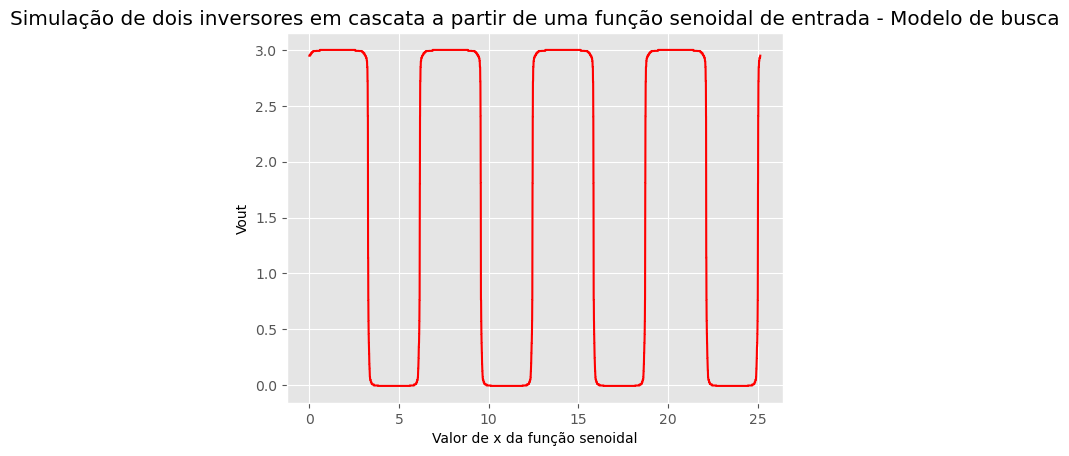

In [112]:
plt.plot(x, Vout2, "r")
plt.title("Simulação de dois inversores em cascata a partir de uma função senoidal de entrada - Modelo de busca")
plt.xlabel("Valor de x da função senoidal")
plt.ylabel("Vout")
plt.show()

## Modelo Sigmoid

In [113]:
# Função de sigmoid para ser utilizada na otimização de curvas do scipy
def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

In [114]:
x_data = df["input"].values
y_data = df["output"].values

initial_optimize = [max(y_data), np.median(x_data), 1, min(y_data)]

In [115]:
from scipy.optimize import curve_fit

# Otimizando a função sigmoid
params_opt, covariance = curve_fit(sigmoid, x_data, y_data, initial_optimize, method="dogbox")

In [116]:
# Valor de desvio padrão dos erros encontrados na otimização de cada parâmetro
err = np.sqrt(np.diag(covariance))
err

array([0.03638753, 0.0050373 , 0.38743038, 0.02031632])

Note-se que o erro encontrado dos parâmetros é baixo, o que faz com que, empiricamente, a acurácia do modelo seja ótima.

In [117]:
# Calculando o erro quadrático médio do modelo

predict = sigmoid(x_data, *params_opt)
mse = np.sum(np.power(y_data - predict, 2)) / len(x_data)
mse

0.00927174283878776

O erro quadrático do modelo é baixíssimo, o que faz refletir a relação dos modelos de treinamento com a curva sigmoid.

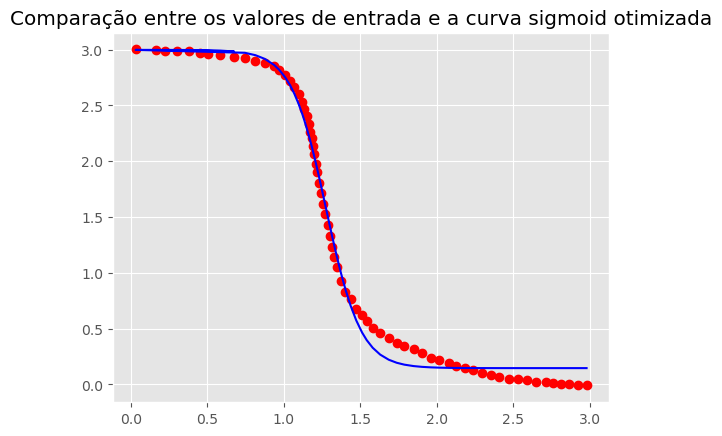

In [118]:
# Plotando a comparação

plt.plot(x_data, y_data, "ro")
plt.plot(x_data, predict, "b")
plt.title("Comparação entre os valores de entrada e a curva sigmoid otimizada")
plt.show()

### Criando o gráfico da simulação

In [119]:
# Adquirindo o valor de saída do primeiro inversor
Vout1 = sigmoid(Vin, *params_opt)

# Adqurindo o valor de saída final
Vout2 = sigmoid(Vout1, *params_opt)

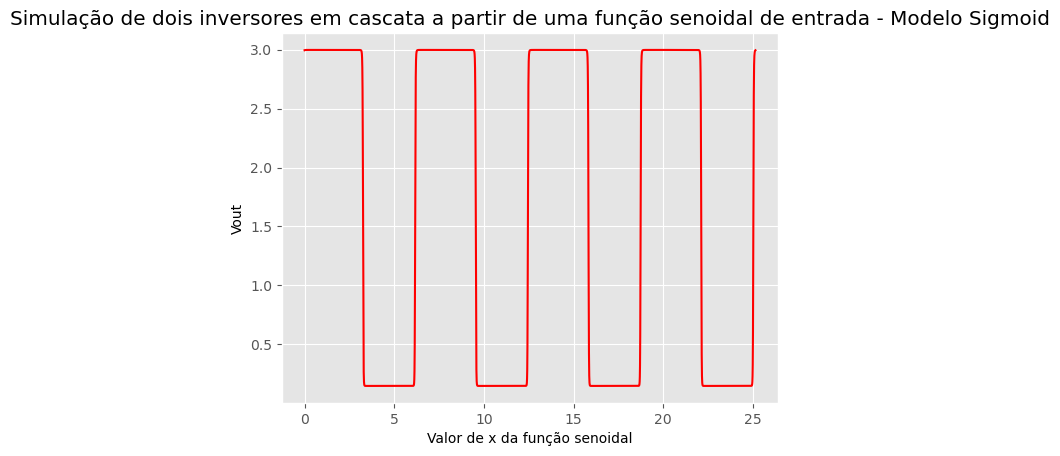

In [120]:
plt.plot(x, Vout2, "r")
plt.title("Simulação de dois inversores em cascata a partir de uma função senoidal de entrada - Modelo Sigmoid")
plt.xlabel("Valor de x da função senoidal")
plt.ylabel("Vout")
plt.show()

## Conclusão

Portanto, nota-se que os dois modelos foram ótimos em relação a representar graficamente a simulação de dois inversores em cascatas, com um ponto a mais para o sigmoid por representar de forma ótima e sem *overfitting* dos dados.